### TreeCorr is a package for efficiently computing 2-point and 3-point correlation functions.
documentation: https://rmjarvis.github.io/TreeCorr/_build/html/overview.html


In [18]:
import astropy.io.fits as fits
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table,join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import treecorr
import pymc as pm
import arviz as az




# Assuming you have the path to the FITS file stored in thesis_path
fits_file_path = os.path.join('/Volumes/data/Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits')  # Replace with your actual file name



In [19]:
t= Table.read(fits_file_path)

masked = os.path.join('/Volumes/data/SN-C3_masked_cat.fits')  # Replace with your actual file name

t3= Table.read(masked)


In [20]:
t=join(t,t3,keys='id')


t.rename_column('ra_1','ra')
t.rename_column('dec_1','dec')

In [23]:
fits_random = os.path.join('/Volumes/data/SN-C3_randoms_ugriz_trim_video.fits') 

# Open the FITS file using astropy.io.fits
hdulist = fits.open(fits_random)
hdulist.info()

t2= Table.read(fits_random)

Filename: /Volumes/data/SN-C3_randoms_ugriz_trim_video.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SN-C3_C01_randoms_raw.fits    1 BinTableHDU     18   13402307R x 3C   [E, E, 9A]   


In [25]:
ra_2 = t2['ra'][::1000]
dec_2 = t2['dec'][::1000]

random_catalog=SkyCoord(ra=ra_2*u.deg, dec=dec_2*u.deg)


## Select catalog subset !!!

In [26]:
# Select redshift subset 
subset = (t['z'] > 0.6) & (t['z'] < 0.7) & (t['SM']>10.5)& (t['SM']<11) #solar masses

# Extract right ascension (ra) and declination (dec) arrays from the subset
ra_subset = t['ra'][subset] #[::100]
dec_subset = t['dec'][subset]#[::100]


# Create a TreeCorr Catalog object
ra=ra_subset*u.deg
dec=dec_subset*u.deg



In [27]:
config = {
    'ra_col': 'ra',
    'dec_col': 'dec',
    'ra_units': 'deg',
    'dec_units': 'deg',
    'min_sep': 0.003,  # Define the minimum separation
    'max_sep': 1.78,   # Define the maximum separation
    'bin_size': 0.1, # Define the desired bin size (adjust as needed)
    'sep_units':'deg'

}

#catalog= SkyCoord(ra=ra_subset * u.deg, dec=dec_subset * u.deg)
cat1 = treecorr.Catalog(ra=ra, dec=dec, config=config, npatch=50)  # my catalog subset
cat2 = treecorr.Catalog(ra= ra_2, dec= dec_2, config=config, npatch=50)

In [28]:

#treecorr.NNCorrelation class requires two mandatory parameters: min_sep and max_sep.
#These parameters define the minimum and maximum separation distances considered when calculating the correlation function.

dd = treecorr.NNCorrelation(config) #var_method='bootstrap'
rr = treecorr.NNCorrelation(config)

 

In [29]:
dd.process(cat1)   
rr.process(cat2) 

In [30]:
rd = treecorr.NNCorrelation(config) 
dr = treecorr.NNCorrelation(config)

In [31]:
rd.process(cat1, cat2)   
dr.process(cat1, cat2) 

In [32]:
dd.calculateXi(rr=rr, dr=dr)

(array([ 2.28057963e+00,  3.48993135e+00,  5.00299500e-01,  2.08884868e+00,
         5.19965031e-01,  8.99976783e-01,  5.90493976e-01,  1.18116486e+00,
         9.32076511e-01,  3.04385258e-01, -7.64927095e-02,  4.03178872e-01,
         6.77147714e-01,  2.57335454e-01,  6.77992644e-01,  9.28363949e-01,
         4.22478504e-01,  5.22355440e-01,  4.86740446e-01,  3.44482076e-01,
         3.16812625e-01,  2.45752923e-01,  5.32375213e-01,  2.76096764e-01,
         3.22906753e-01,  1.85015603e-01,  9.65348906e-02,  1.50987520e-01,
         1.34149484e-01,  1.79433138e-01,  1.60194878e-01,  1.53709764e-01,
         1.04454935e-01,  7.38471280e-02,  1.50365277e-01,  8.76786080e-02,
         8.57443482e-02,  3.99365978e-02,  5.60255346e-02,  7.10143642e-02,
         7.74171035e-02,  9.08248547e-02,  9.06351293e-02,  9.82321694e-03,
         7.50587245e-02,  3.94879132e-02,  7.05453737e-03,  2.80887776e-02,
        -9.58729632e-03,  2.31084773e-02,  1.63753063e-02, -1.87175156e-03,
         3.5

In [81]:
diag = dd.estimate_cov(method='shot') #  In this case, the returned value will only be the diagonal.
std= np.sqrt(diag)
print(std)

[0.73815969 0.67083315 0.60986072 0.55457151 0.50448994 0.45901349
 0.41768078 0.38005677 0.34586445 0.31482292 0.28668703 0.26116786
 0.2380225  0.21701158 0.19797678 0.18070532 0.16506581 0.15088489
 0.13801735 0.12623096 0.11534379 0.10527036 0.09601517 0.08755248
 0.07982523 0.07279073 0.06640585 0.06059032 0.05530721 0.05051987
 0.04616005 0.04217039 0.03851973 0.03521903 0.03223734 0.02954515
 0.02707611 0.02480569 0.02273278 0.02065532 0.01855416 0.01690333
 0.01560861 0.01442889 0.01335756 0.01243667 0.01150695 0.01053939
 0.00975985 0.0091411  0.00857939 0.00791986 0.00736236 0.00686757
 0.00637989 0.00597912 0.00561955 0.00541318 0.00527663 0.00535524
 0.00561321 0.00605997 0.00725227 0.01011553]


In [83]:
theta_edges=np.linspace(-2.5,0.25,50) #-2.5 and 0.25 are log of the max and min separation in degrees
theta_cen= (theta_edges[:-1]+theta_edges[1:])/2


In [84]:
deg_theta_cen=10**theta_cen

w_fit= 2e-2* deg_theta_cen**(-0.8)
cuts=(deg_theta_cen>3e-3) & (deg_theta_cen <1) #define valid values
X= deg_theta_cen[cuts]
Y= w_fit[cuts]




In [85]:
from astropy.cosmology import Planck15
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font',**{'family':'serif','size':18})
plt.rc('text', usetex=True) # comment out this line if you don't have latex installed


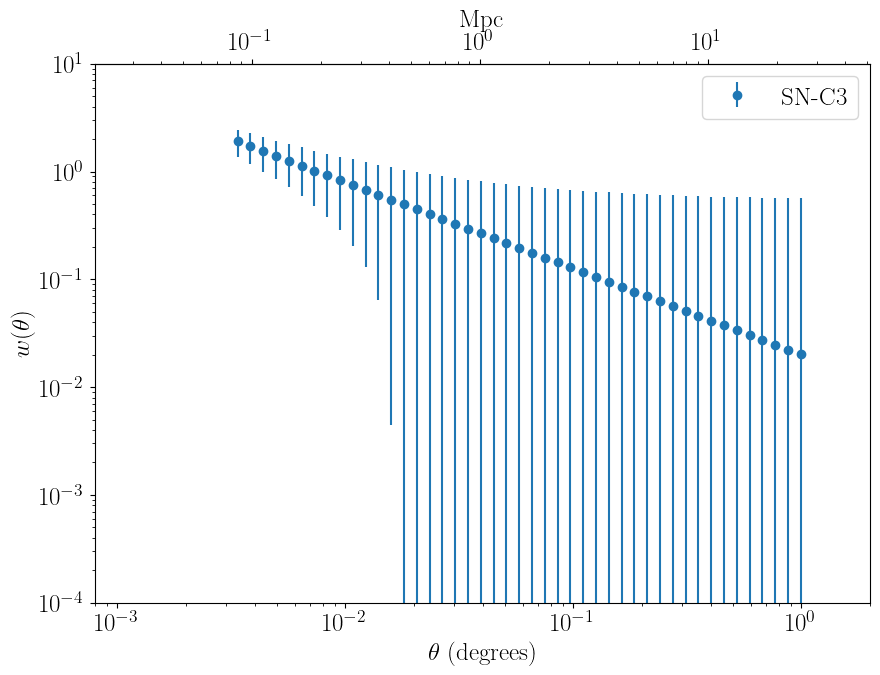

In [93]:

w_fit_subset = w_fit[cuts]

# Plot standard deviations
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
ax.errorbar(deg_theta_cen[cuts], w_fit_subset, yerr=std, fmt='o', label='SN-C3')
ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$w(\theta)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,10.])
ax.set_xlim([8e-4,2.])
secax = ax.secondary_xaxis('top',functions=(lambda x: x*Planck15.kpc_proper_per_arcmin(z_mean).value*60./1e3,
                                   lambda x: x*Planck15.arcsec_per_kpc_proper(z_mean).value*1e3/3.6e3))
secax.set_xlabel(r'Mpc')
ax.legend()
